# Pump It Up Challenge: Modelizacion predictiva del estado funcional de bombas de agua en Tanzania

--------------------------------------------------------------------------------------------------------------------------------------

## Importo las Librerias Necesarias

In [1]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier 
from xgboost.sklearn import XGBClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# Configuro pandas para que me muestre todas las columnas de un dataframe
pd.set_option('display.max_columns', None)

## Cargo los Datos

In [3]:
# Se leen los archivos csv con pandas.
data_train = pd.read_csv("..\\data\\Training_set_values.csv")
labels_train = pd.read_csv('..\\data\\Training_set_labels.csv')
data_test = pd.read_csv('..\\data\\Test_set_values.csv') 

In [4]:
# Realizo un merge de los datos de train y la variable traget.
data = pd.merge(data_train, labels_train, on= 'id')

## EDA, Limpieza y Preprocesado de los datos

### 0. Introduccion

In [5]:
# Info inicial del dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

El dataset contiene 59400 registros, con un total de 40 columnas. Cada fila representa un pozo de agua de Tanzania, y cada columna es una caracteristica del pozo en cuestion.
Pueden observarse que algunas variables no estan tipificadas correctamente (por ejemplo date_recorded es una variable tipo object cuando deberia ser datetime), y que otras contienen registros nulos (como por ejemplo la variable funder, installer, public_meeting, scheme_name).
Los pasos que voy a llevar a cabo en esta primera parte de preprocesamiento y limpieza de los datos seguiran el orden siguiente:

- Tipificacion de variables. Correccion de valores extraños, nulos encubiertos o codificados.
- Investigar la incidencia de outliers y corregir.
- Explorar la incidecia de valores nulos. Gestion de los mismos.
- Analisis exploratorio de la utilidad de las variables preprocesadas de cara al modelo de clasificacion (analisis de correlacion y tests de asociacion).

En cada fase iré analizando variable por variable.

### 1. Tipificacion de variables. Correccion de valores extraños/nulos codificados

#### Amount_tsh

In [6]:
# Se observa alta incidencia de ceros en la variable (70%), y una distribucion con una desviacion a la derecha.
print(data.amount_tsh.describe(), '\n\n', data.amount_tsh.value_counts(normalize=True).sort_values(ascending=False).head())

count     59400.000000
mean        317.650385
std        2997.574558
min           0.000000
25%           0.000000
50%           0.000000
75%          20.000000
max      350000.000000
Name: amount_tsh, dtype: float64 

 amount_tsh
0.0       0.700993
500.0     0.052222
50.0      0.041616
1000.0    0.025051
20.0      0.024630
Name: proportion, dtype: float64


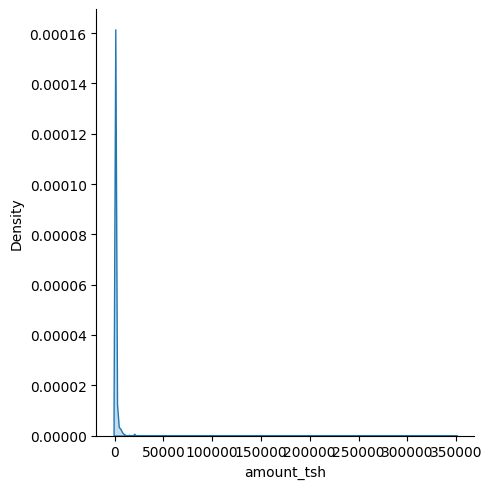

In [7]:
sns.displot(data.amount_tsh, kind='kde', fill=True);

#### Date Recorded

In [8]:
# Corrijo el tipo de la variable
data['date_recorded'] = pd.to_datetime(data.loc[:,'date_recorded'])

In [9]:
# Rango de la variable. No hay valores extraños
print(data.date_recorded.min())
print(data.date_recorded.max())

2002-10-14 00:00:00
2013-12-03 00:00:00


#### Funder

In [10]:
# Variable categorica con alta cardinalidad (mas de dos mil categorias)
data.funder = data.funder.astype('category')
data.funder.describe()

count                      55763
unique                      1896
top       Government Of Tanzania
freq                        9084
Name: funder, dtype: object

#### Gps_height

In [11]:
# Se observa presencia de valores negativos, aunque la altura sobre el nivel del mar minima de Tanzania es cero. Se consideraran estos valores negativos como nulos.
data.gps_height.describe()

count    59400.000000
mean       668.297239
std        693.116350
min        -90.000000
25%          0.000000
50%        369.000000
75%       1319.250000
max       2770.000000
Name: gps_height, dtype: float64

In [12]:
data.loc[data.gps_height < 0 , 'gps_height'] = np.nan

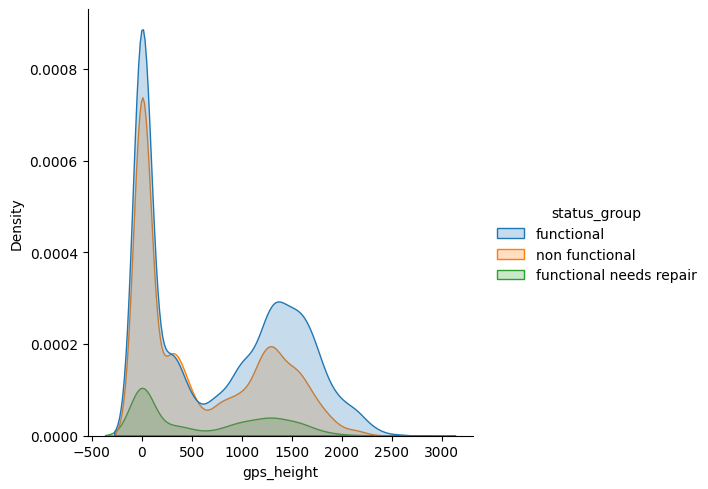

In [13]:
# Distribucion bimodal, con desviacion a la derecha. Existe bastante solapamiento entre las clases, no parece aportar mucha informatividad.
sns.displot(x= (data.gps_height), kind='kde', fill=True, hue= data.status_group);

#### Installer

In [14]:
# Variable categorica con alta cardinalidad
data.installer = data.installer.astype('category')
data.installer.describe()

count     55745
unique     2145
top         DWE
freq      17402
Name: installer, dtype: object

#### Longitude y Latitude

In [15]:
# Se redondean las variables para mayor legibilidad sin tanta perdida de precision en la informacion
data['longitude'] = round(data['longitude'], 2)
data['latitude'] = round(data['latitude'], 2)

In [16]:
# Se observan datos de longitud 0 y latitud 0 (no concuerda con las coordenadas de Tanzania)
data[['longitude', 'latitude']].describe()

,longitude,latitude
count,59400.000000,59400.000000
mean,34.077399,-5.706036
std,6.567432,2.946028
min,0.000000,-11.650000
25%,33.090000,-8.540000
50%,34.910000,-5.020000
75%,37.180000,-3.330000
max,40.350000,-0.000000


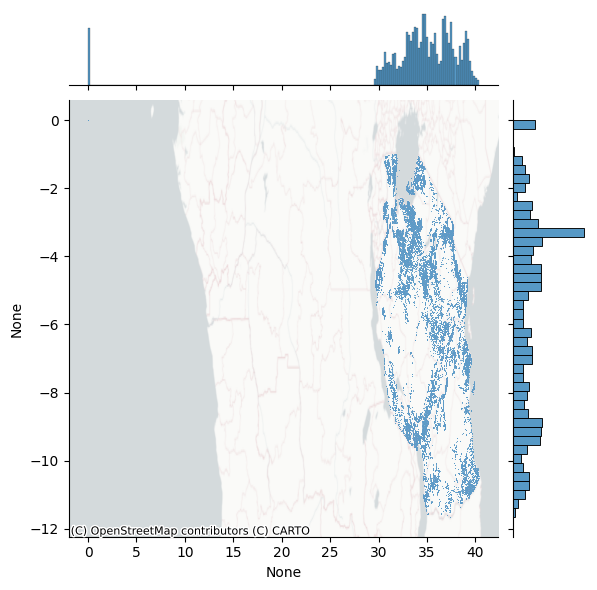

In [17]:
# Voy a graficar los puntos en un mapa para visualizar la distribucion
import geopandas as gpd
import contextily
gdf = gpd.GeoDataFrame(data, geometry= gpd.points_from_xy(data.longitude, data.latitude), crs="EPSG:4326")
gdf = gdf.drop(columns=['longitude', 'latitude'])
joint_axes = sns.jointplot(
    x=gdf.geometry.x, y=gdf.geometry.y, data=gdf, s=0.5
)
contextily.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.PositronNoLabels,
);

Aparece un punto en las coordenadas (0,0) que no pertence al territorio de Tanzania. Convertire las coordenadas de estos registros en valores null.

In [18]:
# El punto (0,0) se corresponde con los valores maximos de latitud y minimos de longitud.
data.loc[data['latitude'] == data['latitude'].max(), 'latitude'] = np.nan
data.loc[data['latitude'].isnull(), 'longitude'] = np.nan

#### Wpt_name

In [19]:
# Variable categorica nominal con alta cardinalidad. Se corrige valor 'none' y tipo de categoria
data.wpt_name = data.wpt_name.astype('category')
data.wpt_name.describe()

count     59398
unique    37399
top        none
freq       3563
Name: wpt_name, dtype: object

In [20]:
data.loc[data['wpt_name'] == 'none', 'wpt_name'] = np.nan

#### Num_private

In [21]:
# Muy alta incidencia de ceros.
data.num_private.describe()

count    59400.000000
mean         0.474141
std         12.236230
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       1776.000000
Name: num_private, dtype: float64

#### Basin, Region, Lga, Ward y Subvillage

Estas variables se analizan juntas (como otras mas adelante), porque todas describen esencialmente la ubicacion geografica de los pozos de agua, solo que con distinto nivel de granularidad

In [22]:
# Se observan algunas variables con alta cardinalidad (ward y subvillage)
data[['basin', 'region', 'lga', 'ward','subvillage']].describe()

,basin,region,lga,ward,subvillage
count,59400,59400,59400,59400,59029
unique,9,21,125,2092,19287
top,Lake Victoria,Iringa,Njombe,Igosi,Madukani
freq,10248,5294,2503,307,508


In [23]:
# Se corrige tipo
data[['basin', 'region', 'lga', 'ward','subvillage']] = data[['basin', 'region', 'lga', 'ward','subvillage']].astype('category')

Se exploraran exhaustivamente las categorias de las variables basin y region. Las demas debido a su alta cardinalidad no pueden explorarse exhaustivamente.

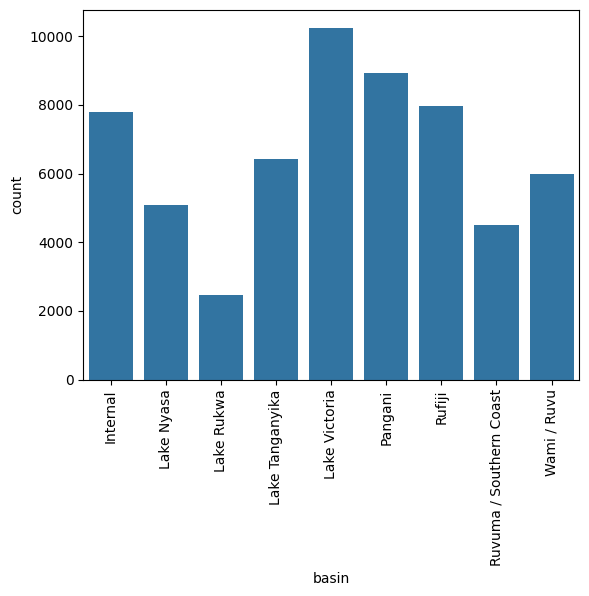

In [24]:
# No hay valores extraños
sns.barplot(data.basin.value_counts())
plt.xticks(rotation=90);

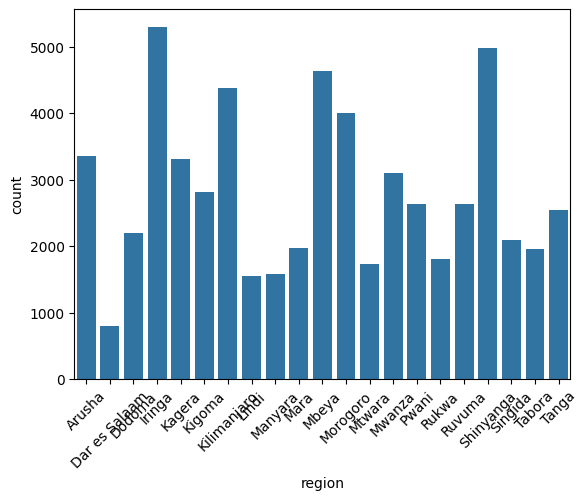

In [25]:
# No hay valores extraños
sns.barplot(data.region.value_counts())
plt.xticks(rotation=45);

#### Region_code, District_code

In [26]:
# Las variables estan tipificadas como numericas pero deberian ser categoricas
data[['region_code', 'district_code']].describe()

,region_code,district_code
count,59400.000000,59400.000000
mean,15.297003,5.629747
std,17.587406,9.633649
min,1.000000,0.000000
25%,5.000000,2.000000
50%,12.000000,3.000000
75%,17.000000,5.000000
max,99.000000,80.000000


In [27]:
# Algunas regiones tienen mas de un codigo asignado. En algunos casos parece un error de codificacion (commo Lindi y Mtwara). Entiendo que esta variable deberia coincidir con
# la informacion que aporta la variable 'Region'. Por ende no voy a modificar nada en esta variable, que es candidata a ser eliminada mas adelante.
data.groupby([data.region.astype('object'), data.region_code]).agg('id').count().reset_index().sort_values(by='region')

,region,region_code,id
0,Arusha,2,3024
1,Arusha,24,326
2,Dar es Salaam,7,805
3,Dodoma,1,2201
4,Iringa,11,5294
5,Kagera,18,3316
6,Kigoma,16,2816
7,Kilimanjaro,3,4379
8,Lindi,8,300
9,Lindi,18,8


In [28]:
# Modifico el tipo de las variables, ya que se trata de variables categoricas (no numericas)
data.region_code = data.region_code.astype('category')
data.district_code = data.district_code.astype('category')

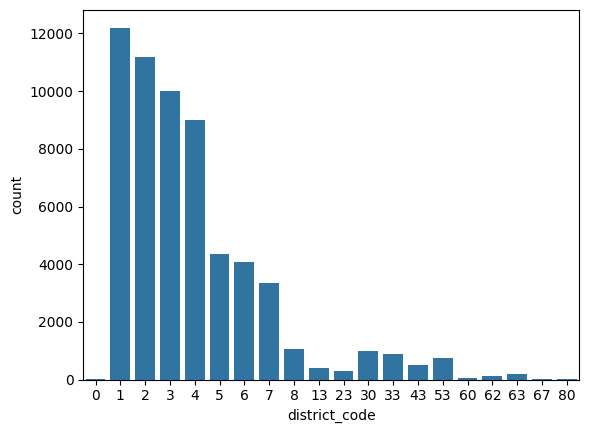

In [29]:
# Voy a mantener esta variable sin cambios puesto que no se exactamente a que corresponde un distrito. No parece haber valores extraños o nulos codificados
sns.barplot(data.district_code.value_counts());

#### Population

In [30]:
# Se observa un 36% de ceros. Se interpretan estos valores como nulos.
print(data.population.describe(), '\n')
print(data.population.value_counts(normalize=True).sort_values(ascending=False)[:5])

count    59400.000000
mean       179.909983
std        471.482176
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64 

population
0      0.359949
1      0.118266
200    0.032660
150    0.031852
250    0.028300
Name: proportion, dtype: float64


In [31]:
data.loc[data.population == 0, 'population'] = np.nan

#### Public Meeting

In [32]:
# Posee valores nulos y amplia mayoria de valores True.
data.public_meeting = data.public_meeting.astype('category')
data.public_meeting.describe()

count     56066
unique        2
top        True
freq      51011
Name: public_meeting, dtype: object

#### Recorded_by

In [33]:
# Esta variable posee un solo valor. Será eliminada puesto que no brinda ningun tipo de informacion al modelo
data.recorded_by.describe()

count                       59400
unique                          1
top       GeoData Consultants Ltd
freq                        59400
Name: recorded_by, dtype: object

In [34]:
data = data.drop(columns = ['recorded_by'])

#### Scheme_management, Scheme_name

In [35]:
# Scheme name es una variable con alta cardinalidad. No parece haber valores extraños o nulos codificados
data[['scheme_management', 'scheme_name']].describe()

,scheme_management,scheme_name
count,55522,30590
unique,11,2695
top,VWC,K
freq,36793,682


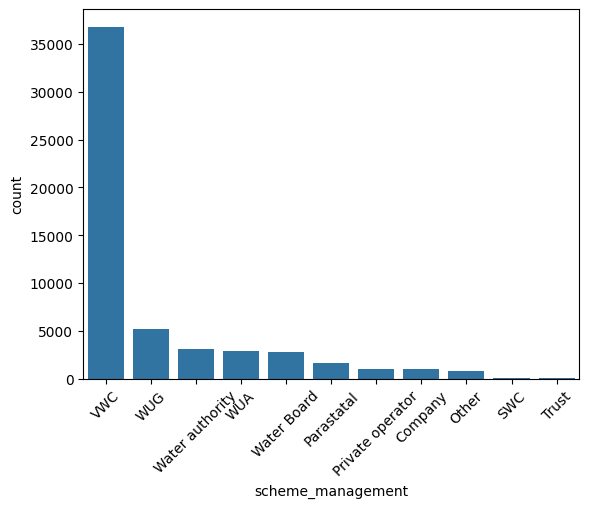

In [36]:
# Scheme_management no tiene una cardinalidad alta, no tiene nulos ni valores extraños, podria ser util. Sera explorada mas adelante
sns.barplot(data.scheme_management.value_counts())
plt.xticks(rotation=45);

In [37]:
# Corrijo tipo
data[['scheme_management', 'scheme_name']] = data[['scheme_management', 'scheme_name']].astype('category')

#### Permit

In [38]:
# Posee algunos valores nulos y mayoria de valores True.
data.permit = data.permit.astype('category')
data.permit.describe()

count     56344
unique        2
top        True
freq      38852
Name: permit, dtype: object

#### Construction Year

In [39]:
# Considerable presencia de ceros. Seran convertidos a valores null.
print(data.construction_year.describe(), '\n')
print(data.construction_year.value_counts().sort_index().head())

count    59400.000000
mean      1300.652475
std        951.620547
min          0.000000
25%          0.000000
50%       1986.000000
75%       2004.000000
max       2013.000000
Name: construction_year, dtype: float64 

construction_year
0       20709
1960      102
1961       21
1962       30
1963       85
Name: count, dtype: int64


In [40]:
data.loc[data['construction_year'] == 0, 'construction_year'] = np.nan

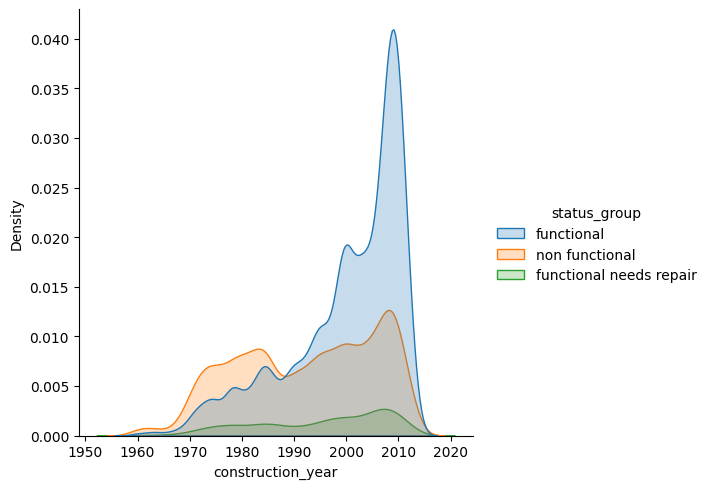

In [41]:
# En el histograma se observa una distribucion con desviacion hacia la izquierda. Parece haber cierto patron en la distribucion de las clases, con mayor numero de pozos no funcionales
# construidos en años previos a 1990, y con un mayor numero de pozos funcionales construidos recientemente. 
sns.displot(x= data.construction_year, kind='kde', fill=True, hue= data.status_group)

#### Extraction_type, Extraction_type_group, Extraction_type_class

In [42]:
data[['extraction_type_class', 'extraction_type_group', 'extraction_type']].describe()

,extraction_type_class,extraction_type_group,extraction_type
count,59400,59400,59400
unique,7,13,18
top,gravity,gravity,gravity
freq,26780,26780,26780


In [43]:
# La categoria 'other-mkulima/shinyanga' de la variable extraction_type se puede incluir dentro de la categoria 'other-playpump' para reducir categorias casi sin perdida de informacion
data.groupby(['extraction_type_class', 'extraction_type_group', 'extraction_type']).agg('id').count().reset_index()

,extraction_type_class,extraction_type_group,extraction_type,id
0,gravity,gravity,gravity,26780
1,handpump,afridev,afridev,1770
2,handpump,india mark ii,india mark ii,2400
3,handpump,india mark iii,india mark iii,98
4,handpump,nira/tanira,nira/tanira,8154
5,handpump,other handpump,other - mkulima/shinyanga,2
6,handpump,other handpump,other - play pump,85
7,handpump,other handpump,other - swn 81,229
8,handpump,other handpump,walimi,48
9,handpump,swn 80,swn 80,3670


In [44]:
# La categoria 'other-mkulima/shinyanga' de la variable extraction_type se puede incluir dentro de la categoria 'other-playpump' para reducir categorias casi sin perdida de informacion
data['extraction_type'] = np.where(data.extraction_type == 'other-mkulima/shinyanga', 'other-playpump', data.extraction_type)

In [45]:
# Corrijo el tipo
data[['extraction_type_class', 'extraction_type_group', 'extraction_type']] = data[['extraction_type_class', 'extraction_type_group', 'extraction_type']].astype('category')

#### Management, management_group

In [46]:
# Baja cardinalidad, presencia de categorias mayoritarias.
data[['management', 'management_group']].describe()

,management,management_group
count,59400,59400
unique,12,5
top,vwc,user-group
freq,40507,52490


In [47]:
# Presencia de valores nulos ('unknown')
data.groupby(['management_group','management']).agg('id').count().reset_index()

,management_group,management,id
0,commercial,company,685
1,commercial,private operator,1971
2,commercial,trust,78
3,commercial,water authority,904
4,other,other,844
5,other,other - school,99
6,parastatal,parastatal,1768
7,unknown,unknown,561
8,user-group,vwc,40507
9,user-group,water board,2933


In [48]:
# Se convierte unknown a valores nulos. Se unen categorias 'other' y 'other-school' de la variable management, para simplificar.
data['management'] = np.where(data.management == 'unknown', np.nan, data.management)
data['management_group'] = np.where(data.management_group == 'unknown', np.nan, data.management_group)
data['management'] = np.where(data.management == 'other-school', 'other', data.management)

In [49]:
# Corrijo el tipo
data[['management', 'management_group']] = data[['management', 'management_group']].astype('category')

#### Payment, Payment_type

In [50]:
# Ambas variables tienen la misma informacion. Una de ellas será eliminada.
data.groupby(['payment_type', 'payment']).agg('id').count().reset_index()

,payment_type,payment,id
0,annually,pay annually,3642
1,monthly,pay monthly,8300
2,never pay,never pay,25348
3,on failure,pay when scheme fails,3914
4,other,other,1054
5,per bucket,pay per bucket,8985
6,unknown,unknown,8157


In [51]:
# Se convierte valor 'unknown' a null
data['payment'] = np.where(data.payment == 'unknown', np.nan, data.payment)

In [52]:
data = data.drop(columns = ['payment_type'])

In [53]:
# Corrijo el tipo
data['payment'] = data['payment'].astype('category')

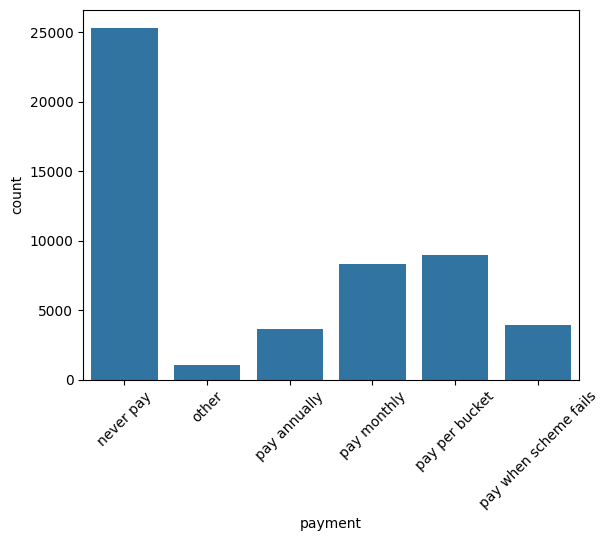

In [54]:
# No hay valores extraños o nulos encubiertos
sns.barplot(data.payment.value_counts())
plt.xticks(rotation=45);

#### Water quality, quality_group

In [55]:
# Hay muy poca diferencia de informacion entre una variable y otra. Por simplicidad eliminare una de ellas.
data.groupby(['water_quality', 'quality_group']).agg('id').count().reset_index()

,water_quality,quality_group,id
0,coloured,colored,490
1,fluoride,fluoride,200
2,fluoride abandoned,fluoride,17
3,milky,milky,804
4,salty,salty,4856
5,salty abandoned,salty,339
6,soft,good,50818
7,unknown,unknown,1876


In [56]:
# Se convierte valor 'unknown' a null
data['water_quality'] = np.where(data.water_quality == 'unknown', np.nan, data.water_quality)

# Elimino variable
data = data.drop(columns=['quality_group'])

# Corrijo el tipo 
data.water_quality = data.water_quality.astype('category')

#### Quantity, quantity_group

In [57]:
# Ambas variables tienen la misma informacion. Eliminare una.
data.groupby(['quantity', 'quantity_group']).agg('id').count().reset_index()

,quantity,quantity_group,id
0,dry,dry,6246
1,enough,enough,33186
2,insufficient,insufficient,15129
3,seasonal,seasonal,4050
4,unknown,unknown,789


In [58]:
# Se convierte valor 'unknown' a null
data['quantity'] = np.where(data.quantity == 'unknown', np.nan, data.quantity)

# Elimino variable
data = data.drop(columns=['quantity_group'])

# Corrijo tipo
data.quantity = data.quantity.astype('category')

#### Source, source type, source class

In [59]:
# No hay valores extraños ni valores nulos codificados.
data.groupby(['source_class', 'source_type','source']).agg('id').count().reset_index()

,source_class,source_type,source,id
0,groundwater,borehole,hand dtw,874
1,groundwater,borehole,machine dbh,11075
2,groundwater,shallow well,shallow well,16824
3,groundwater,spring,spring,17021
4,surface,dam,dam,656
5,surface,rainwater harvesting,rainwater harvesting,2295
6,surface,river/lake,lake,765
7,surface,river/lake,river,9612
8,unknown,other,other,212
9,unknown,other,unknown,66


In [60]:
# Se convierte el valor 'unknown' a 'other' en la variable source para reunir categorias residuales sin perdida significativa de informacion
data['source'] = np.where(data['source']=='unknown', 'other', data['source'])

In [61]:
# Corrijo el tipo
data[['source_class', 'source_type','source']] = data[['source_class', 'source_type','source']].astype('category')

#### Waterpoint_type, Waterpoint_type_group

In [62]:
# Las variable waterpoint_type no aporta un alto nivel de detalle. Se explorará mas adelante si vale la pena mantener ambas variables en el modelo.
data.groupby(['waterpoint_type_group', 'waterpoint_type']).agg('id').count().reset_index()

,waterpoint_type_group,waterpoint_type,id
0,cattle trough,cattle trough,116
1,communal standpipe,communal standpipe,28522
2,communal standpipe,communal standpipe multiple,6103
3,dam,dam,7
4,hand pump,hand pump,17488
5,improved spring,improved spring,784
6,other,other,6380


In [63]:
# Corrijo el tipo
data[['waterpoint_type_group', 'waterpoint_type']] = data[['waterpoint_type_group', 'waterpoint_type']].astype('category')

### 2. Incidencia y Gestion de Outliers

Se explorará graficamente la distribucion de las variables cuantitativas para detectar la presencia de valores outliers/fuera de rango.

In [64]:
varcont = data.select_dtypes(include=['int64', 'float64', 'datetime']).drop(columns = ['id'])
varcont.head(3)

,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,population,construction_year
0,6000.0,2011-03-14,1390.0,34.94,-9.86,0,109.0,1999.0
1,0.0,2013-03-06,1399.0,34.70,-2.15,0,280.0,2010.0
2,25.0,2013-02-25,686.0,37.46,-3.82,0,250.0,2009.0


#### Amount_tsh

Como se habia observado previamente, se observa una incidencia muy alta de ceros (70%). Voy a crear una nueva variable que sea una version categorizada de 'amount_tsh',
con dos categorias: 'cero' y 'no_cero'. Mas adelante, cuando explore la relacion de las variables independientes con la objetivo voy a decidir quedarme con alguna de las dos.

amount_tsh
0.00    0.700993
0.20    0.000051
0.25    0.000017
1.00    0.000051
2.00    0.000219
Name: proportion, dtype: float64


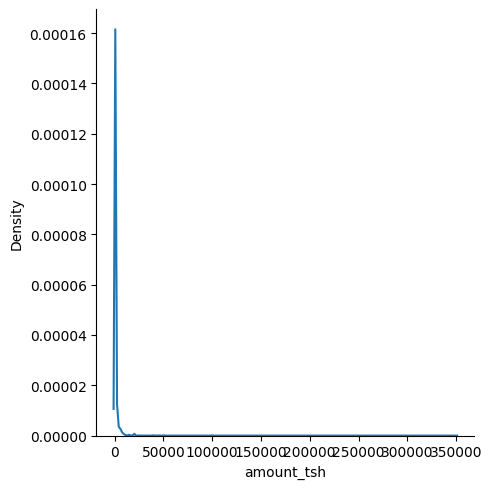

In [65]:
sns.displot(data.amount_tsh, kind = 'kde')
print(data.amount_tsh.value_counts(normalize=True).sort_index().head())

In [66]:
# Creo nueva variable categorica
amount_tsh_cat = np.where(data['amount_tsh'] == 0, 1, 0)
data.insert(2,'amount_tsh_cat', amount_tsh_cat)
data.amount_tsh_cat = data.amount_tsh_cat.astype('category')

#### Date_recorded

In [67]:
print("Fecha mas antigua de registro: {} \nFecha mas reciente de registro: {}".format(data.date_recorded.min().date(), data.date_recorded.max().date()))

Fecha mas antigua de registro: 2002-10-14 
Fecha mas reciente de registro: 2013-12-03


No aparecen valores fuera de rango en las fechas registradas

#### GPS_height

Valor minimo de altura: 0.0. 
Valor maximo de altura: 2770.0


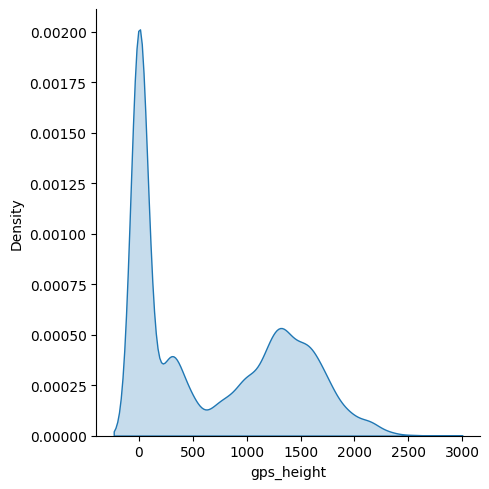

In [68]:
# No se encuentran outliers
sns.displot(data.gps_height, kind='kde', fill=True)
print('Valor minimo de altura: {}. \nValor maximo de altura: {}'.format(data.gps_height.min(),data.gps_height.max()))

#### Longitude y Latitude

Estas variables fueron exploradas en el paso previo, se convirtieron a valores nulos las coordenadas que aparecian como 'outliers' (eran puntos que no correspondian al territorio de Tanzania).
Procedo a pintar nuevamente los puntos sobre el mapa (esta vez sin esos valores outliers) para comprobar que el proceso de limpieza ha sido exitoso.

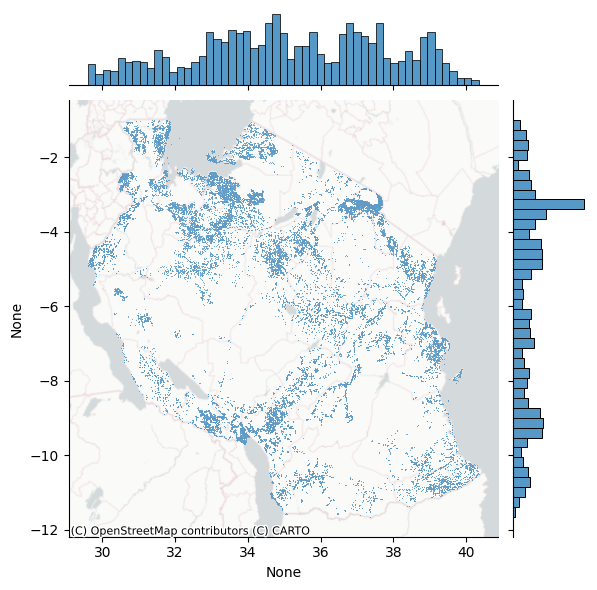

In [69]:
gdf = gpd.GeoDataFrame(data, geometry= gpd.points_from_xy(data.longitude, data.latitude), crs="EPSG:4326")
gdf = gdf.drop(columns=['longitude', 'latitude'])
joint_axes = sns.jointplot(
    x=gdf.geometry.x, y=gdf.geometry.y, data=gdf, s=0.5
)
contextily.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.PositronNoLabels,
);

#### Num private

Esta variable contiene un 98% de ceros. No la tendre en cuenta para entrenar el modelo de clasificacion por este motivo (aporta muy poca informacion al modelo).

num_private
0    0.987256
1    0.001229
2    0.000387
3    0.000455
4    0.000337
Name: proportion, dtype: float64


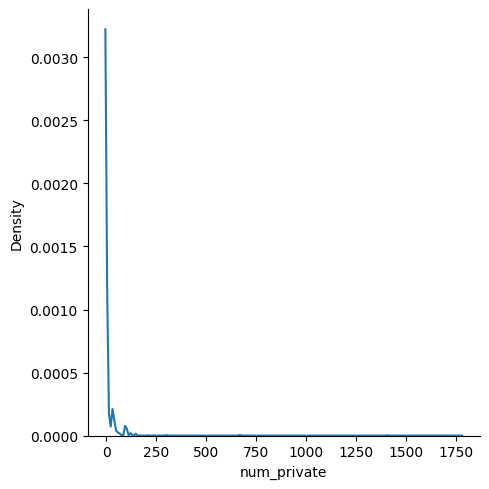

In [70]:
sns.displot(data.num_private, kind='kde')
print(data.num_private.value_counts(normalize=True).sort_index()[:5])

In [71]:
data = data.drop(columns=['num_private'])

#### Population

count    38019.000000
mean       281.087167
std        564.687660
min          1.000000
25%         40.000000
50%        150.000000
75%        324.000000
max      30500.000000
Name: population, dtype: float64


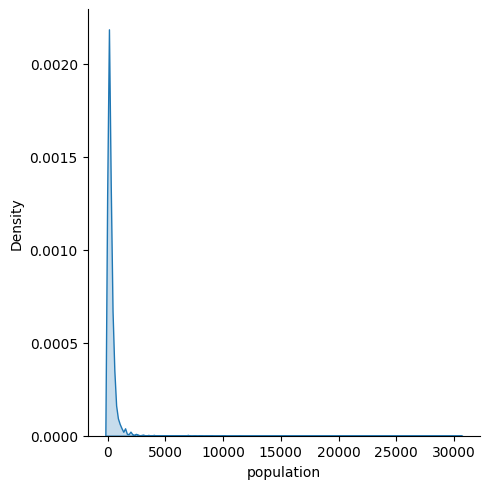

In [72]:
sns.displot(data.population, kind='kde', fill=True);
print(data.population.describe())

Previamente impugne los valores 0 (los converti a valores nulos) porque me pareció un valor nulo codificado. Analizando nuevamente la distribucion de los valores de esta variable y con ayuda del grafico, me doy cuenta de que esta variable presenta una considerable desviacion a la derecha en su distribucion, concentrando la mayor parte de los registros en valores relativamente bajos de poblacion pero con valores maximos muy alejados del valor medio. No parece haber valores extraños/fuera de rango.

En la proxima fase gestionare los valores nulos generados previamente. 

#### Construction Year

No aparecen valores fuera de rango en esta variable.

count    38691.000000
mean      1996.814686
std         12.472045
min       1960.000000
25%       1987.000000
50%       2000.000000
75%       2008.000000
max       2013.000000
Name: construction_year, dtype: float64


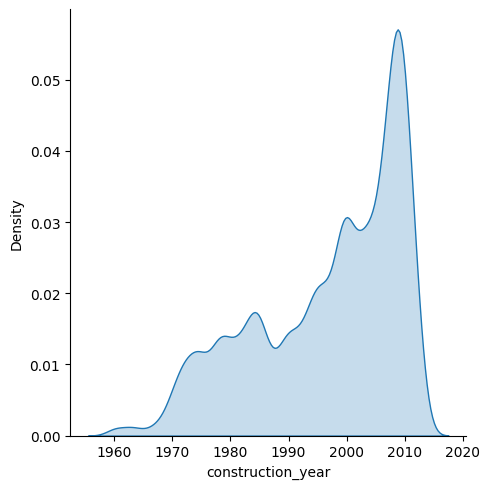

In [73]:
sns.displot(data.construction_year, kind='kde', fill=True)
print(data.construction_year.describe())

### 3. Incidencia y Gestion de Valores Nulos

In [74]:
# Incidencia de valores nulos por columna del dataframe.
data.apply(lambda x: x.isna().sum() / len(data) *100).round(3).sort_values(ascending=False).head(20)

scheme_name          48.502
population           35.995
construction_year    34.864
payment              13.732
scheme_management     6.529
installer             6.153
funder                6.123
wpt_name              6.002
public_meeting        5.613
permit                5.145
water_quality         3.158
latitude              3.051
longitude             3.051
gps_height            2.519
quantity              1.328
management            0.944
management_group      0.944
subvillage            0.625
amount_tsh_cat        0.000
amount_tsh            0.000
dtype: float64

Me parece que imputar los valores nulos de scheme_name podria ser un error porque podria llevar a cambiar drasticamente la distribucion original de la variable, ya que contiene casi un 50% de valores nulos. Voy a eliminar esta variable.

In [75]:
data = data.drop(columns=['scheme_name'])

A continuacion exploro si hay patrones en los valores missings, para tenerlos en cuenta como una caracteristica mas a ser incorporada en el modelo clasificatorio.

In [76]:
# Creo lista con los nombres de la columnas que contienen valores nulos
nulls = data.apply(lambda x: x.isna().sum() / len(data) *100).round(3).sort_values(ascending=False)
columnas_imputar = nulls[nulls > 0].index.tolist()

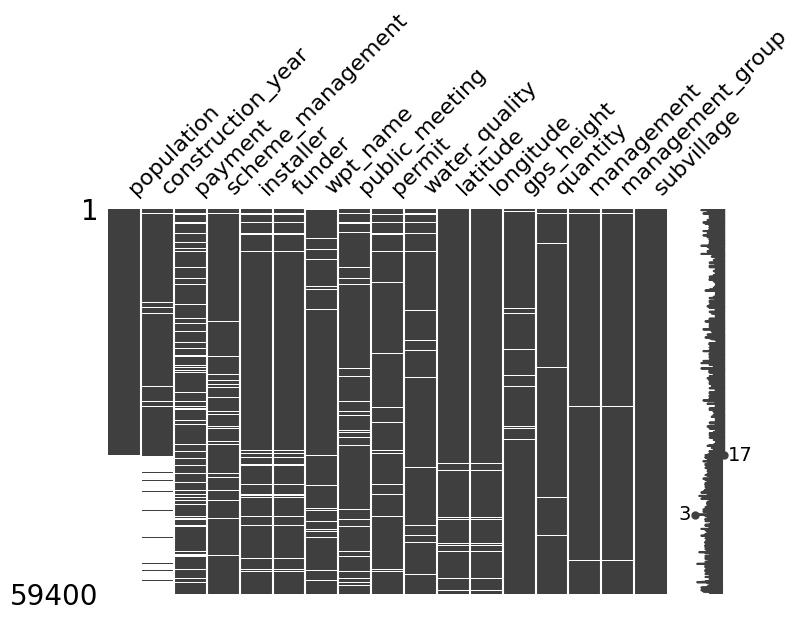

In [77]:
import missingno as msno

msno.matrix(data[columnas_imputar].sort_values(by= 'population'), figsize= (8, 5));

Aparecen patrones de asociacion en los valores missings en las siguientes columnas:  

- Population y Construction_year

- Installer, Funder y Permit

- Water quality y quantity con payment

- Long y Lat con population y construction_year


Voy a optar por una estrategia de imputacion simple por valores medios en caso de variables cuantitativas, y por valores modales en caso de variables cualitativas.

In [78]:
# Loop para imputar todas las columnas que lo requieran
for i in range(len(columnas_imputar)):
    if data[columnas_imputar[i]].dtypes == 'category':
        data.loc[data[columnas_imputar[i]].isnull(), columnas_imputar[i]] = data[columnas_imputar[i]].describe().top
    elif data[columnas_imputar[i]].dtypes == 'float64':
        data.loc[data[columnas_imputar[i]].isnull(), columnas_imputar[i]] = data[columnas_imputar[i]].mean()

In [79]:
# Chequeo que la imputacion de valores nulos se haya llevado a cabo con exito
data.apply(lambda x: x.isna().sum() / len(data) *100).round(3).sort_values()

id                       0.0
amount_tsh               0.0
amount_tsh_cat           0.0
date_recorded            0.0
funder                   0.0
gps_height               0.0
installer                0.0
longitude                0.0
latitude                 0.0
wpt_name                 0.0
basin                    0.0
subvillage               0.0
region                   0.0
region_code              0.0
district_code            0.0
lga                      0.0
ward                     0.0
population               0.0
public_meeting           0.0
scheme_management        0.0
permit                   0.0
construction_year        0.0
extraction_type          0.0
extraction_type_group    0.0
extraction_type_class    0.0
management               0.0
management_group         0.0
payment                  0.0
water_quality            0.0
quantity                 0.0
source                   0.0
source_type              0.0
source_class             0.0
waterpoint_type          0.0
waterpoint_typ

In [80]:
# Ahora que no tiene nulos, corrijo el tipo de esta variable.
data['construction_year'] = data['construction_year'].astype('int64')

### 4. Analisis de Variables frente a Variable Objetivo

En este apartado realizo un analisis exploratorio de las variables independientes para chequear el nivel de asociacion con la variable target. El objetivo de esta fase es identificar variables que potencialmente sean utiles en el modelo clasificatorio, y fundamentalmente, explorar la posibilidad de simplificar un poco el modelo. 
Se pondra especial enfasis en el analisis de variables categoricas con alta cardinalidad, para ver si vale la pena mantenerlas.

En cuanto a las variables cuantitativas, durante la primera fase de exploracion fui pintando la distribucion de las mismas con las clases de la variable objetivo. Para alcanzar una medida cuantitativa mas objetiva que el analisis visual tambien realicé tests de asociacion parametricos y no parametricos (ANOVA y Kruskal-Wallis), y ambos tipos de test arrojaban datos similares, con estadisticos muy elevados y un p-valor despreciable. No inclui estos tests aqui porque me parecio que no arrojaban informacion importante, y porque no estoy seguro de que los supuestos para aplicar estos test se cumplan en este caso.

In [81]:
import scipy.stats as stats
import plotly.express as px

# Defino funcion para obtener el valor V de Cramer de cada variable categorica vs la variable objetivo
def cramers_v(var1, varObj):
    data = pd.crosstab(var1, varObj).values
    vCramer = stats.contingency.association(data, method = 'cramer')
    return vCramer

In [82]:
# Lista de columnas categoricas
cat_cols = data.drop(columns= ['id','status_group']).select_dtypes(include='category').columns.values.tolist()

# DataFrame con los valores de V de Cramer de cada variable
tablaCramer = pd.DataFrame(data[cat_cols].apply(lambda x: cramers_v(x,data['status_group'])),columns=['VCramer'])

# Grafico de los valores 
px.bar(tablaCramer,x=tablaCramer.VCramer,title='Relaciones frente a Status Group').update_yaxes(categoryorder="total ascending").show()

En este grafico se puede observar que en general las variables que tienen mas nivel de granularidad o describen de manera mas especifica un pozo de agua presentan valores de V de Cramer mas altos, por ejemplo, la variable 'extraction_type' tiene un valor de asociacion con la variable target mas alto que la variable 'extraction_type_group', que a su vez tiene un valor mas alto que 'extraction_type_class'.

Esto puede ser una primera guia para seleccionar variables, pero me parece que es necesario proceder con cierto criterio. El problema seria quedarse solo con variables que describan muy especificamente los pozos de agua, con el riesgo de overfitting del modelo clasificatorio. Esto se ve con claridad en la variable 'wpt_name' que describe el nombre del pozo, informacion que deberia ser irrelevante para el estado funcional del mismo, y sin embargo se encuentra en lo mas alto de esta lista de valores V de Cramer.
La conclusion que saco de este grafico es que primero debere tomar una desicion con respecto a las variables con alta cardinalidad, para evitar posible overfitting, pero al mismo tiempo tratando de recortar lo menos posible para encontrar un buen equilibrio.

Voy a eliminar entonces las primeras cinco variables que aparecen en este grafico, que coinciden con las variables con cardinalidad mas alta (por encima de 2000 categorias).

In [83]:
data = data.drop(columns= tablaCramer.sort_values(by=['VCramer'], ascending=False).index.values.tolist()[:5])

Ademas voy a eliminar las variables 'scheme_management' y 'waterpoint_type_group' que dejé para este momento, puesto que las variables 'management' y 'waterpoint_type' aportan informacion muy similar (para evitar colinealidad), por simpleza, y porque estas ultimas presentan un valor mas alto de V de Cramer frente a la variable objetivo.

In [84]:
data = data.drop(columns = ['scheme_management', 'waterpoint_type_group'])

In [85]:
# Pruebas que realicé: 

#data = data.drop(columns= ['amount_tsh'])
#data = data.drop(columns= ['region_code'])

# Manteniendo ambas variables mejora el rendimiento del modelo.

Por ultimo voy a crear nuevas variables a partir de la variable 'date recorded', para sumar caracteristicas a la matriz de entrada al modelo y para evitar el formato datetime.
Luego elimino la columna date_recorded.

In [86]:
data.insert(2, 'recorded_año', data.date_recorded.dt.year)
data.insert(3, 'recorded_mes', data.date_recorded.dt.month)

In [87]:
# Creo variable recorded_season dividiendo el año en cuatro trimestres
recorded_season = []
for i in data.recorded_mes:
    if i >= 1 and i <= 3:
        recorded_season.append(1)
    elif i >= 4 and i <= 6:
        recorded_season.append(2)
    elif i >= 7 and i <= 9:
        recorded_season.append(3)
    elif i >= 10 and i <= 12:
        recorded_season.append(4)
data.insert(4, 'recorded_season', recorded_season)

In [88]:
# Elimino las columnas redundates
data = data.drop(columns = ['date_recorded'])

### 5. Procesamiento de los Datos de Test

In [89]:
# Defino funcion para llevar a cabo cada uno de los cambios que hice en el train set
def procesa_df(dftest, dftrain):
    # Cambio date a datetime
    dftest['date_recorded'] = pd.to_datetime(dftest.loc[:,'date_recorded'])

    # Elimino columnas
    dftest = dftest.drop(columns=['funder', 'installer', 'wpt_name', 'num_private', 'subvillage', 'ward', 'recorded_by', 'scheme_management', 'scheme_name',
                                  'payment_type', 'quality_group', 'quantity_group', 'waterpoint_type_group'])
    
    # Paso nulos codificados a nulos
    dftest.loc[dftest.gps_height < 0 , 'gps_height'] = np.nan
    dftest['longitude'] = round(dftest['longitude'], 2)
    dftest['latitude'] = round(dftest['latitude'], 2)
    dftest.loc[dftest['latitude'] == dftest['latitude'].max(), 'latitude'] = np.nan
    dftest.loc[dftest['latitude'].isnull(), 'longitude'] = np.nan
    dftest.loc[dftest.population == 0, 'population'] = np.nan
    dftest.loc[dftest['construction_year'] == 0, 'construction_year'] = np.nan
    dftest['extraction_type'] = np.where(dftest.extraction_type == 'other-mkulima/shinyanga', 'other-playpump', dftest.extraction_type)
    dftest['management'] = np.where(dftest.management == 'unknown', np.nan, dftest.management)
    dftest['management_group'] = np.where(dftest.management_group == 'unknown', np.nan, dftest.management_group)
    dftest['management'] = np.where(dftest.management == 'other-school', 'other', dftest.management)
    dftest['payment'] = np.where(dftest.payment == 'unknown', np.nan, dftest.payment)
    dftest['water_quality'] = np.where(dftest.water_quality == 'unknown', np.nan, dftest.water_quality)
    dftest['quantity'] = np.where(dftest.quantity == 'unknown', np.nan, dftest.quantity)
    dftest['source'] = np.where(dftest['source']=='unknown', 'other', dftest['source'])

    # Convierto variables object a category
    dftest[dftest.select_dtypes(include='object').columns.values.tolist()] = dftest[dftest.select_dtypes(include='object').columns.values.tolist()].astype('category')
    dftest[['region_code','district_code']] = dftest[['region_code','district_code']].astype('category')

    # Creo variable categorica binaria amount_tsh_cat
    amount_tsh_cat = np.where(dftest['amount_tsh'] == 0, 1, 0)
    dftest.insert(2,'amount_tsh_cat', amount_tsh_cat)
    dftest.amount_tsh_cat = dftest.amount_tsh_cat.astype('category')

    # Creo las variables de año, mes y season a partir de date_recorded. Elimino date_recorded
    dftest.insert(2, 'recorded_año', dftest.date_recorded.dt.year)
    dftest.insert(3, 'recorded_mes', dftest.date_recorded.dt.month)
    recorded_season = []
    for i in dftest.recorded_mes:
        if i >= 1 and i <= 3:
            recorded_season.append(1)
        elif i >= 4 and i <= 6:
            recorded_season.append(2)
        elif i >= 7 and i <= 9:
            recorded_season.append(3)
        elif i >= 10 and i <= 12:
            recorded_season.append(4)
    dftest.insert(4, 'recorded_season', recorded_season)
    dftest = dftest.drop(columns = ['date_recorded'])

    # Imputo valores nulos utilizando media y moda calculada en train
    nulls = dftest.apply(lambda x: x.isna().sum() / len(dftest) *100).round(3).sort_values(ascending=False)
    columnas_imputar = nulls[nulls > 0].index.tolist()
    for i in range(len(columnas_imputar)):
        if dftest[columnas_imputar[i]].dtypes == 'category':
            dftest.loc[dftest[columnas_imputar[i]].isnull(), columnas_imputar[i]] = dftrain[columnas_imputar[i]].describe().top
        elif dftest[columnas_imputar[i]].dtypes == 'float64':
            dftest.loc[dftest[columnas_imputar[i]].isnull(), columnas_imputar[i]] = dftrain[columnas_imputar[i]].mean()
    dftest['construction_year'] = dftest['construction_year'].astype('int64')
    return dftest

In [90]:
data_test = procesa_df(data_test, data)

In [91]:
data_test.head()

,id,amount_tsh,recorded_año,recorded_mes,recorded_season,amount_tsh_cat,gps_height,longitude,latitude,basin,region,region_code,district_code,lga,population,public_meeting,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quantity,source,source_type,source_class,waterpoint_type
0,50785,0.0,2013,2,1,1,1996.0,35.29,-4.06,Internal,Manyara,21,3,Mbulu,321.0,True,True,2012,other,other,other,parastatal,parastatal,never pay,soft,seasonal,rainwater harvesting,rainwater harvesting,surface,other
1,51630,0.0,2013,2,1,1,1569.0,36.66,-3.31,Pangani,Arusha,2,2,Arusha Rural,300.0,True,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,soft,insufficient,spring,spring,groundwater,communal standpipe
2,17168,0.0,2013,2,1,1,1567.0,34.77,-5.00,Internal,Singida,13,2,Singida Rural,500.0,True,True,2010,other,other,other,vwc,user-group,never pay,soft,insufficient,rainwater harvesting,rainwater harvesting,surface,other
3,45559,0.0,2013,1,1,1,267.0,38.06,-9.42,Ruvuma / Southern Coast,Lindi,80,43,Liwale,250.0,True,True,1987,other,other,other,vwc,user-group,never pay,soft,dry,shallow well,shallow well,groundwater,other
4,49871,500.0,2013,3,1,0,1260.0,35.01,-10.95,Ruvuma / Southern Coast,Ruvuma,10,3,Mbinga,60.0,True,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,soft,enough,spring,spring,groundwater,communal standpipe


### 6. Encoding del Dataset

In [92]:
# Preprocesamiento de los strings para que el LabelEncoder funcione correctamente
for i in data.select_dtypes(include= 'category').columns.values.tolist():
    data[i] = data[i].apply(lambda x: x.lower() if isinstance(x, str) else x)  # Convierto los strings a lowercase
    data[i] = data[i].apply(lambda x: x.replace(" ", "") if isinstance(x, str) else x) # Elimino espacios blancos

# Preprocesamiento sobre el test set
for i in data_test.select_dtypes(include= 'category').columns.values.tolist():
    data_test[i] = data_test[i].apply(lambda x: x.lower() if isinstance(x, str) else x)
    data_test[i] = data_test[i].apply(lambda x: x.replace(" ", "") if isinstance(x, str) else x)

In [93]:
# Lista de variables categoricas
cat_cols = data.select_dtypes(include='category').columns.values.tolist()

In [94]:
# Codifico las variables categoricas con LabelEncoder
le = LabelEncoder()
for col in cat_cols:
    data[col] = le.fit_transform(data[col])
    data_test[col] = le.transform(data_test[col])

In [95]:
# Codifico la variable taget manualmente 
data['status_group'] = data['status_group'].replace(to_replace={'functional': 0, 'non functional': 1, 'functional needs repair': 2})

## Entrenamiento, Validacion y Evaluacion de Modelos

En este apartado seguiré la siguiente metodología:

- Defino funciones para la evaluacion de los modelos.
- Realizo una evaluacion inicial del rendimiento de distintos modelos aplicando el método de validacion cruzada repetida estratificada. De este paso se elije el modelo con mejor rendimiento para pasar a la proxima fase.
- Se realiza mediante GridSearch un tuneado de hiperparametros del modelo escogido en la fase previa.
- Se entrena el modelo final con hiperparametros optimizados sobre el set de entrenamiento.
- Validacion del modelo frente al set de test. Obtencion de metricas y graficos de rendimiento del modelo para realizar tareas de clasificacion (prediccion del estado de las bombas).

#### 0. Funciones

In [96]:
# Funcion para evaluar importancia relativa de las variables independientes en los modelos
def feature_importances (model, X, y):
  model.fit(X, y)
  features= X.columns
  importances = np.round(model.feature_importances_,3) 
  indices = np.argsort(importances)
  num_features = len(features)
  fig, ax = plt.subplots(figsize=(5,5)) 
  plt.barh(range(num_features), importances[indices[-num_features:]],  align='center')
  plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
  plt.xlabel('Relative Importance')
  plt.title('Feature Importance')
  plt.show()

In [97]:
# Se define la funcion para evaluar los modelos con K fold cross validation
def model_evaluation(models, score, X, y):
      results = []
      names = []
      #Para cada modelo
      for name, model in models:
          warnings.filterwarnings('ignore')
          # Genero un StratifiedKFold
          KF = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 98)

          # Hago cross_val
          cv_results = cross_val_score(model, X, y, cv = KF, scoring = score, verbose = False)

          # Guardo los resultados:
          results.append(cv_results)
          names.append(name)

          # Muestro los resultados numéricamente:
          print('Metric: {} , KFold '.format(str(score)))
          print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()))

      return None

#### 1. Evaluacion Inicial

In [98]:
# Realizo la particion train-test (80/20) sobre los datos del df de entrenamiento para luego evaluar y validar los modelos
X = data.drop(columns=['id', 'status_group'])
y = data['status_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify= y, random_state=1234)

In [99]:
# Instancio los modelos y aplico la funcion de evaluacion definida previamente sobre cada uno.
models = [
         ("GaussianNB",GaussianNB()),
         ('KNNClassifier', KNeighborsClassifier()),
         ("DecisionTreeClassifier", DecisionTreeClassifier()),
         ("RandomForestClassifier", RandomForestClassifier(random_state=1234, n_estimators=10)),
         ('XGBoostClassifier', XGBClassifier(random_state=1234))
]

evaluation_score = "accuracy"

model_evaluation(models,  evaluation_score, X_train, y_train)

Metric: accuracy , KFold 
GaussianNB: 0.557786 (0.010671) 
Metric: accuracy , KFold 
KNNClassifier: 0.706187 (0.005067) 
Metric: accuracy , KFold 
DecisionTreeClassifier: 0.753598 (0.006632) 
Metric: accuracy , KFold 
RandomForestClassifier: 0.791351 (0.005374) 
Metric: accuracy , KFold 
XGBoostClassifier: 0.793645 (0.006425) 


El modelo con mejor rendimiento resulta ser el XGBoostClassifier, con un accuracy score de 0.793645 (std=0.006425, no hay evidencia de overfitting). Este sera el modelo elegido para pasar a la siguiente fase de tuneado de hiperparametros.

No obstante, como el rendimiento del modelo RandomForest es bastante cercano al del XGBoost, tambien lo tendre en cuenta para hacer un tuneado de hiperparametros.

#### 2. Tuneado de Hiperparametros

In [100]:
# Construyo el diccionario con listas de hiperparametros a ser evaluados por grid_search
model = XGBClassifier()
n_estimators = [100, 150, 200, 250] 
colsample_bytree = [0.1, 0.2, 0.3]
eta = [0.2, 0.3, 0.4]
max_depth = [6, 8, 10, 12]

grid = dict(n_estimators=n_estimators, colsample_bytree= colsample_bytree, eta= eta, max_depth=max_depth)

In [101]:
# Instancio el objeto grid_search
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

In [102]:
# Entreno el objeto grid_search
# grid_result = grid_search.fit(X_train, y_train)
# print("Mejor accuracy: %f usando los parámetros %s" % (grid_result.best_score_, grid_result.best_params_))

Mejor accuracy: 0.804398 usando los parametros {'colsample_bytree': 0.3, 'eta': 0.2, 'max_depth': 12, 'n_estimators': 100}

#### 3. Entrenamiento y Evaluacion del Modelo Final

In [103]:
# Entreno el modelo final con los hiperparametros previamente especificados por grid_search
xgbclf = XGBClassifier(colsample_bytree= 0.3, eta= 0.2, n_estimators= 100, max_depth=12, random_state=1234)
xgbclf.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.2, eval_metric=None,
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, ...)

In [104]:
# Realizo un predict sobre el set de test para luego construir la matriz de confusion y el classification report
from sklearn.metrics import classification_report
y_pred = xgbclf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85      6452
           1       0.86      0.77      0.81      4565
           2       0.61      0.33      0.43       863

    accuracy                           0.81     11880
   macro avg       0.76      0.67      0.70     11880
weighted avg       0.81      0.81      0.80     11880



Conclusiones: En el classification report se puede observar que las metricas que miden el rendimiento del modelo son mejores para las clases mayoritarias y peores para la clase minoritaria, como era de esperar.

El modelo demostro su mejor desempeño a la hora de reconocer bombas que no necesitaban reparacion, con un recall de 91% sobre esta clase. Por contraposicion le costo mas reconocer bombas que necesitaban reparacion (recall 77%) y mucho mas aun bombas que estaban funcionales pero necesitaban reparacion (recall 32%).

Desde el punto de vista de la precision, el modelo acierta con mayor eficacia para las bombas que estan ok y para las que no funcionan, acertando en un 80-85% de sus predicciones, pero su capacidad predictiva baja a un 62% para las bombas que funcionan pero necesitan reparacion.

El accuracy general se ubica en 0.81, lo cual no parece un mal score dados los scores de accuracy historicos que se obtuvieron en la competicion de Driven Data.

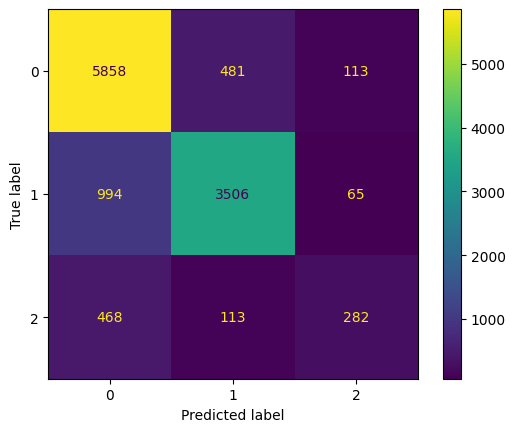

In [105]:
# Grafico de matriz de confusion
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
cm_display
plt.show()

Conclusiones: Lo ideal seria que la amplia mayoria de registros se ubiquen en la diagonal principal de esta matriz de confusion. Como puede observarse, para las clases 0 y 1 esto se acerca un poco al ideal, pero el caso es muy distinto para la clase 2, incluso la mayor parte de los registros de la clase 2 fueron clasificados como clase 0 por el modelo (esta es la razon por la que el recall es tan bajo para la clase 2, pues el modelo incurre en muchos falsos negativos para esta clase, con un sesgo a predecir hacia la clase 0, que es la clase mayoritaria). 

En cuanto a la clase 1, si bien el poder predictivo del modelo es aceptablemente bueno (porque la mayoria de los registros clasificados como 1 por el modelo son en realidad 1; ver la columna de la clase 1 de la matriz de confusion), el mayor incoveniente como se habia visto previamente es el recall. Es decir, el modelo incurre en muchos falsos negativos para esta clase (1011 instancias de clase 1 clasificados como clase 0 por el modelo), perdiendo muchos casos de clase 1 en el camino. Como es de esperar el modelo confunde mas que nada porque predice demasiados registros como clase 0, puesto que se trata de la amplia mayoria de los registros. Seria sorprendente si el recall de la clase 1 fuera bajo porque el modelo predice demasiados registros como clase 2, pero no es el caso.

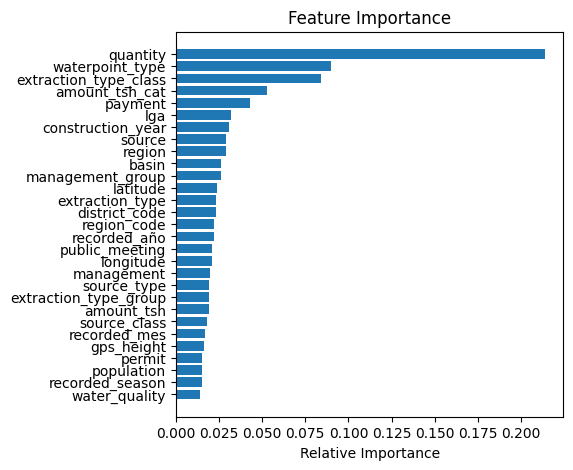

In [106]:
feature_importances(xgbclf, X, y)

Conclusiones: En este grafico podemos apreciar en que medida influyen las variables recogidas en el modelo para realizar las predicciones. Como puede observarse en los primeros puestos, las variables con mayor peso a la hora de realizar las predicciones fueron la cantidad de agua que recibe el pozo de agua, el tipo de extraccion con el que se bombea el agua, el tipo de bomba de agua, y si se trata de un servicio pago o no.

Este grafico puede utilizarse para realizar otras pruebas del rendimiento del modelo con seleccion de variables, concentrando esfuerzos en las variables con mejor puntuacion.

Tambien puede ser util para la toma de decisiones a la hora de evaluar el estado de las bombas, o para gestionar recursos (por ejemplo, para investigar mas detenida y directamente en el campo el comportamiento de ciertas variables en relacion al estado funcional de las bombas, y extraer conclusiones valiosas que permitan mejorar la calidad y/o la durabilidad de las bombas de agua en el futuro).

#### 4. Submission Final

A continuacion se entrena el mejor modelo nuevamente sobre los datos completos de train (los que originalmente se bajan de la pagina del concurso), para luego hacer un predict sobre los datos de test. De esta manera se prepara el dataframe que será subido a la pagina de DrivenData como un archivo .csv con dos columnas, segun los requisitos del concurso.

In [107]:
# Entreno nuevamente el mejor modelos sobre los datos completos de train.
xgbclf = XGBClassifier(colsample_bytree= 0.3, eta= 0.2, n_estimators= 100, max_depth=12, random_state=1234)
xgbclf.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.2, eval_metric=None,
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, ...)

In [108]:
# Creo el DataFrame con las predicciones, modificando los codigos numericos por los labels originales de la variable target segun los requisitos del concurso
predicciones = xgbclf.predict(data_test.drop(columns='id'))
predicciones = pd.Series(predicciones)
submission = pd.DataFrame(data= predicciones.values, index= data_test['id'].values)
submission.columns = ['status_group']
submission.index.name = 'id'
submission['status_group'] = submission['status_group'].replace(to_replace={0:'functional', 1:'non functional', 2:'functional needs repair'})

In [ ]:
# Guardo el DataFrame como archivo .csv
#submission.to_csv(r'submissionXGB.csv')  # -------------------------------------------------> Score obtenido: 0.8176

#### 5. Extra: VotingClassifier

En este ultimo apartado se explora el rendimiento de dos modelos mas:

- RandomForestClassifier, buscando previamente los mejores hiperparametros con GridSearch.
- VotingClassifier, para juntar los criterios de los dos mejores modelos durante la fase de evaluacion inicial: XGBoost y RandomForest.

Como considero esta parte como un extra al proyecto, en este caso no realizaré particion train/test de los datos ni tampoco pintaré metricas o graficos para evaluar el desempeño de estos modelos. En cambio, entrenaré a los modelos directamente sobre los datos de train completos y realizaré el predict sobre los datos de test para armar directamente el DataFrame que será subido a la pagina del concurso.

In [110]:
# Busqueda de mejores hiperparametros del RandomForest
model = RandomForestClassifier()
n_estimators = [100, 150, 200, 250] 
max_features = ['sqrt', 'log2']
min_samples_split = [6, 7, 8, 9, 10]
max_depth = [30, 50, 60, 70]

grid = dict(n_estimators=n_estimators, max_features= max_features, min_samples_split= min_samples_split, max_depth=max_depth)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(X_train, y_train)
# print("Mejor accuracy: %f usando los parámetros %s" % (grid_result.best_score_, grid_result.best_params_))

Mejor accuracy: 0.807449 usando los parametros {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 8, 'n_estimators': 250}

In [111]:
# Entrenamiento del RFClassifier (sobre los datos completos de train directamente)
rfclf = RandomForestClassifier(max_depth= 30, max_features= 'sqrt', min_samples_split= 8, n_estimators= 250, random_state=1234)
rfclf.fit(X, y)

RandomForestClassifier(max_depth=30, min_samples_split=8, n_estimators=250,
                       random_state=1234)

In [112]:
# Construyo el DataFrame con las predicciones
predicciones = rfclf.predict(data_test.drop(columns='id'))
predicciones = pd.Series(predicciones)
submission = pd.DataFrame(data= predicciones.values, index= data_test['id'].values)
submission.columns = ['status_group']
submission.index.name = 'id'
submission['status_group'] = submission['status_group'].replace(to_replace={0:'functional', 1:'non functional', 2:'functional needs repair'})

In [ ]:
# Guardo el DataFrame con archivo .csv
#submission.to_csv(r'submissionRF.csv')       # ------------------------------------>   Score obtenido: 0.8182

In [114]:
# Construyo el modelo VotingClassifier con los dos mejores modelos con hiperparametros optimizados.
clf1 = XGBClassifier(colsample_bytree= 0.3, eta= 0.2, n_estimators= 100, max_depth=12, random_state=1234)
clf2 = RandomForestClassifier(max_depth= 30, max_features= 'sqrt', min_samples_split= 8, n_estimators= 250, random_state=1234)
eclf = VotingClassifier(estimators=[
    ('xgboost', clf1), ('rf', clf2)], voting='soft')   ## Se intentó con voting 'hard', pero 'soft' da mejor resultado en la competencia
eclf.fit(X, y)

VotingClassifier(estimators=[('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.3, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False, eta=0.2,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interact...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=12,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None, ...)),
                             ('rf',
                              RandomForestClassifier(max_depth=30,
                                                     min_samples_split=8,
                                                     n_estimators=250,
                                                     random_state=1234))],
                 voting='soft')

In [115]:
# Construyo el DataFrame con las predicciones
predicciones = eclf.predict(data_test.drop(columns='id'))
predicciones = pd.Series(predicciones)
submission = pd.DataFrame(data= predicciones.values, index= data_test['id'].values)
submission.columns = ['status_group']
submission.index.name = 'id'
submission['status_group'] = submission['status_group'].replace(to_replace={0:'functional', 1:'non functional', 2:'functional needs repair'})

In [ ]:
#submission.to_csv(r'submissionVClf.csv')  # ---------------------------------------> Score obtenido: 0.8212

------------------------------------------------------------------------------------------------------------------------------------------------------------
Author: Braian E. Sosa
------------------------------------------------------------------------------------------------------------------------------------------------------------